In [88]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime



### osm-netzwerk einlesen

In [89]:
#set_date = "251010" 
set_date = "251022" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

print("number of cycleways:", len(cycleways))
print("number of motorways:", len(motorways))

number of cycleways: 5432755
number of motorways: 69743


In [90]:
cycleways.head()

,osm_id,highway,bicycle,bicycle_forward,bicycle_backward,cycleway,cycleway_left,cycleway_right,cycleway_both,cycleway_lane,...,maxspeed,maxspeed_conditional,maxspeed_backward,maxspeed_forward,maxspeed_type,name,ref,surface,width,geometry
0,99,tertiary,None,None,None,None,None,no,None,None,...,None,None,None,None,None,None,None,asphalt,None,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
1,104,unclassified,None,None,None,None,None,None,no,None,...,50,None,None,None,None,Münzmeisterstraße,None,asphalt,None,"LINESTRING (13.74142 51.02366, 13.74139 51.023..."
2,105,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Altpestitz,None,sett,None,"LINESTRING (13.73698 51.01663, 13.73643 51.016..."
3,107,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Trienter Straße,None,asphalt,None,"LINESTRING (13.73507 51.01914, 13.73505 51.019..."
4,110,residential,None,None,None,None,None,None,no,None,...,50,None,None,None,sign,Heinrich-Greif-Straße,None,concrete:plates,None,"LINESTRING (13.74296 51.02871, 13.74295 51.028..."


In [91]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [92]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk"].isin(["designated"])) |  TODO: add "sidewalk" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

765073

In [93]:
#filtered_cycleways[::10].plot()

In [94]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [95]:
#motorways.plot()

In [96]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 137.811,89 km


In [97]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [98]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10

# 2025-06-07 ## -> 184120 features
# 2025-07-30 ## -> 213732 features
# 2025-08-05 ## -> 214438 features
# 2025-09-08 ## -> 220510 features

# filter to cw only
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]
# drop duplicates if any
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw




Dates found in filenames: ['2025-10-11']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
2,POINT (8.29728 54.87519),2016-09-06,1820694428091863,2016-09-06,regulatory--shared-path-pedestrians-and-bicycl...,8569,5192
34,POINT (8.29949 54.89374),2016-09-06,533889454272406,2016-09-06,regulatory--bicycles-only--g1,8569,5190
40,POINT (8.29982 54.88667),2025-06-27,1098704175663599,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
44,POINT (8.29988 54.88679),2025-06-27,2217948735386355,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
47,POINT (8.29638 54.88012),2016-09-07,500400877822586,2016-09-07,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
...,...,...,...,...,...,...,...
6297807,POINT (8.96308 53.05755),2018-03-18,251362246774370,2018-03-18,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
6297829,POINT (8.964 53.05729),2025-08-16,1462451174804015,2025-08-16,regulatory--dual-path-pedestrians-and-bicycles...,8599,5332
6297834,POINT (8.96359 53.05766),2025-08-16,3058286184362909,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
6297838,POINT (8.96407 53.0572),2017-04-17,129610735792136,2022-04-11,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332


#### Zeitfilter 

In [99]:
##  is newer than 2025-01-01  

# september 2025: 36488
# oktober   2025: 41263


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_trafficsigns_cw)

41263

In [100]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
40,POINT (8.29982 54.88667),2025-06-27,1098704175663599,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
44,POINT (8.29988 54.88679),2025-06-27,2217948735386355,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
48,POINT (8.29996 54.88709),2025-06-27,1270110387694692,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
61,POINT (8.30096 54.88757),2025-06-27,3280755865457874,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
425,POINT (8.31794 54.92832),2022-07-24,603163378052143,2025-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8570,5187
...,...,...,...,...,...,...,...
6297431,POINT (8.90864 53.05984),2025-05-16,1025090599601009,2025-05-16,regulatory--bicycles-only--g1,8597,5332
6297782,POINT (8.96325 53.05715),2025-08-16,3058286197696241,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
6297795,POINT (8.9643 53.05719),2025-08-16,1462451184804014,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
6297829,POINT (8.964 53.05729),2025-08-16,1462451174804015,2025-08-16,regulatory--dual-path-pedestrians-and-bicycles...,8599,5332


In [101]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= 12, axis=1)
]
len(mapillary_trafficsigns_cw_temp)

15437

<Axes: >

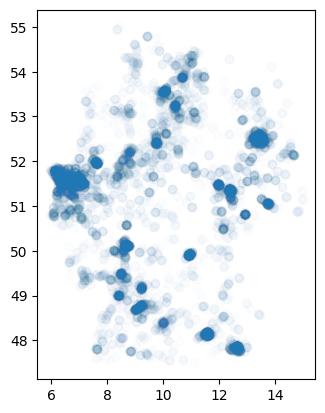

In [102]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [103]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
df_buffered_20 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_20["geometry"] = df_buffered_20.geometry.buffer(20)


df_buffered_30 = df_buffered_30.to_crs(mapillary_trafficsigns_cw_temp.crs)
df_buffered_20 = df_buffered_20.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [104]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [105]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_20 = mark_intersections(df_buffered_20, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [106]:
df_buffered_30["buffer_size"] = 30
df_buffered_20["buffer_size"] = 20

In [107]:
#df_buffered.id.unique()

In [108]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     15314
False      123
Name: count, dtype: int64

In [109]:
df_buffered_20.has_cw_intersection.value_counts()

has_cw_intersection
True     15197
False      240
Name: count, dtype: int64

In [110]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
df_buffered_30.has_mw_intersection.value_counts()

has_mw_intersection
False    15324
True       113
Name: count, dtype: int64

In [111]:
df_buffered_30.has_mw_intersection

425        False
1371       False
1380       False
1447       False
1463       False
           ...  
6295891    False
6297195    False
6297214    False
6297263    False
6297317    False
Name: has_mw_intersection, Length: 15437, dtype: bool

In [112]:
df_buffered_20_false=df_buffered_20[(df_buffered_20.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_20_false)

184

In [113]:
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_30_false)

67

In [114]:
df_buffered_20_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
134935,"POLYGON ((10.8032 54.31009, 10.8032 54.31007, ...",2020-02-07,217260229962801,2025-08-04,regulatory--shared-path-pedestrians-and-bicycl...,8683,5236,False,20
150644,"POLYGON ((11.03479 54.36026, 11.03479 54.36024...",2023-06-08,281304237595910,2025-06-21,regulatory--bicycles-only--g1,8694,5232,False,20
160769,"POLYGON ((12.14103 50.5056, 12.14103 50.50558,...",2021-07-29,373972227580616,2025-09-30,regulatory--shared-path-pedestrians-and-bicycl...,8744,5520,False,20
211149,"POLYGON ((12.37118 51.3614, 12.37118 51.36139,...",2024-02-24,1502416800919119,2025-09-27,regulatory--bicycles-only--g1,8755,5458,False,20
218998,"POLYGON ((12.38027 51.33935, 12.38027 51.33933...",2023-02-05,1001147024182390,2025-08-26,regulatory--shared-path-pedestrians-and-bicycl...,8755,5460,False,20
...,...,...,...,...,...,...,...,...,...
6158434,"POLYGON ((9.54707 48.52289, 9.54707 48.52287, ...",2024-10-11,1340089623883360,2025-10-02,regulatory--shared-path-pedestrians-and-bicycl...,8626,5659,False,20
6206291,"POLYGON ((9.78907 48.4042, 9.78907 48.40418, 9...",2021-09-09,272358531202468,2025-04-30,regulatory--bicycles-only--g1,8637,5667,False,20
6262330,"POLYGON ((10.0977 48.84768, 10.0977 48.84766, ...",2024-06-25,2141806109519610,2025-07-20,regulatory--shared-path-pedestrians-and-bicycl...,8651,5637,False,20
6272655,"POLYGON ((10.23457 48.62019, 10.23457 48.62017...",2021-09-12,551671282819996,2025-06-22,regulatory--shared-path-pedestrians-and-bicycl...,8657,5652,False,20


In [115]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_20_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
20    117
30     67
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [132]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({20: 2, 30: 1}).astype("Int64")

In [133]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio
987617,"POLYGON ((8.58092 49.97958, 8.58092 49.97956, ...",2021-12-03,1327535784350594,2025-05-16,regulatory--shared-path-pedestrians-and-bicycl...,8582,5557,False,NaN,20,2
1711173,"POLYGON ((13.38863 52.53296, 13.38863 52.53294...",2022-02-21,337440064982798,2025-06-11,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2
1706103,"POLYGON ((13.396 52.53258, 13.396 52.53257, 13...",2021-12-22,688809325589033,2025-06-03,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2
1708475,"POLYGON ((13.38857 52.533, 13.38857 52.53298, ...",2016-07-13,534645790905336,2025-09-29,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2
1698645,"POLYGON ((13.38857 52.53297, 13.38857 52.53295...",2021-11-20,430134451982692,2025-09-28,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2
...,...,...,...,...,...,...,...,...,...,...,...
4924215,"POLYGON ((7.08995 51.51333, 7.08995 51.5133, 7...",2017-01-15,504687857337974,2025-04-14,regulatory--dual-path-bicycles-and-pedestrians...,8514,5447,False,False,30,1
5106591,"POLYGON ((7.36877 50.97671, 7.36877 50.97668, ...",2023-11-15,987952138939492,2025-08-11,regulatory--shared-path-pedestrians-and-bicycl...,8527,5486,False,False,30,1
5297125,"POLYGON ((7.98811 50.96308, 7.98811 50.96305, ...",2023-04-18,1157997038228915,2025-08-03,regulatory--dual-path-bicycles-and-pedestrians...,8555,5487,False,False,30,1
5328377,"POLYGON ((8.33857 51.66863, 8.33857 51.6686, 8...",2024-02-25,394575303453637,2025-02-15,regulatory--bicycles-only--g1,8571,5436,False,False,30,1


In [134]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

#### clean up from existing maproulette challenge

In [135]:
### import the the flagged (not created, fixed) tasks from the challenge. 

challenge_gdf = gpd.read_file("challenge_52916_data_f_mr.geojson")
#challenge_gdf.head()

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


154

### retrieve the image ID for the map features

In [136]:
#df_process_img= df_buffered_false.copy()
df_process_img= df_buffered_both_false_no_challenge.copy()

In [137]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 154/154 [00:16<00:00,  9.15it/s]


In [138]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
987617,"POLYGON ((8.58092 49.97958, 8.58092 49.97956, ...",2021-12-03,1327535784350594,2025-05-16,regulatory--shared-path-pedestrians-and-bicycl...,8582,5557,False,NaN,20,2,1186589198532697
1711173,"POLYGON ((13.38863 52.53296, 13.38863 52.53294...",2022-02-21,337440064982798,2025-06-11,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2,636323730989906
1708475,"POLYGON ((13.38857 52.533, 13.38857 52.53298, ...",2016-07-13,534645790905336,2025-09-29,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2,4546188062065217
1698645,"POLYGON ((13.38857 52.53297, 13.38857 52.53295...",2021-11-20,430134451982692,2025-09-28,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2,261316012704830
1705639,"POLYGON ((13.39351 52.53233, 13.39351 52.53231...",2022-02-21,491696679004907,2025-06-26,regulatory--bicycles-only--g1,8801,5372,False,NaN,20,2,258754413099639


In [139]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
5202542,POINT (7.61006 51.94091),2016-06-07,4665113370185377,2025-01-02,regulatory--dual-path-bicycles-and-pedestrians...,8538,5416,False,NaN,20,2,818384362140905
5809526,POINT (8.83953 47.77529),2019-04-20,3999402850143967,2025-01-03,regulatory--shared-path-pedestrians-and-bicycl...,8594,5710,False,NaN,20,2,1925594837605551
2484675,POINT (10.85754 49.85775),2018-02-06,838577090064065,2025-01-07,regulatory--shared-path-pedestrians-and-bicycl...,8686,5566,False,NaN,20,2,1027169718057800
4010387,POINT (10.44559 53.00638),2016-09-01,1714709712067121,2025-01-11,regulatory--shared-path-pedestrians-and-bicycl...,8667,5336,False,NaN,20,2,305627217603998
5596004,POINT (8.39581 48.32764),2020-07-11,378429643521322,2025-01-23,regulatory--shared-path-pedestrians-and-bicycl...,8574,5672,False,NaN,20,2,507836400353956
...,...,...,...,...,...,...,...,...,...,...,...,...
1403185,POINT (11.46184 51.75294),2023-10-28,716787189804960,2025-10-04,regulatory--dual-path-bicycles-and-pedestrians...,8713,5430,False,False,30,1,319434077397425
559115,POINT (7.34036 49.42316),2022-07-30,479470644185309,2025-10-04,regulatory--shared-path-pedestrians-and-bicycl...,8526,5597,False,NaN,20,2,763955788139775
1999102,POINT (12.80151 52.91661),2023-09-10,848724740130015,2025-10-05,regulatory--shared-path-pedestrians-and-bicycl...,8774,5343,False,NaN,20,2,849122963520733
1839536,POINT (13.4531 52.59276),2024-10-16,549869837430528,2025-10-06,regulatory--bicycles-only--g1,8804,5367,False,NaN,20,2,412731555220607


In [140]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [141]:
#centroids

In [142]:
#centroids.plot()

In [143]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist wahrscheinlich nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"] 
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [145]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''